In [54]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib_inline
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.spatial.ckdtree import coo_entries

DATA = 'data'

In [55]:
production = pd.read_csv(os.path.join(DATA, "palm-oil-production.csv"))
production.head()

,Entity,Code,Year,"Crops - Oil, palm - 257 - Production - 5510 - tonnes"
0,Africa,NaN,1961,1131882
1,Africa,NaN,1962,1111006
2,Africa,NaN,1963,1145004
3,Africa,NaN,1964,1160831
4,Africa,NaN,1965,1138860


In [56]:
production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3468 entries, 0 to 3467
Data columns (total 4 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   Entity                                                3468 non-null   object
 1   Code                                                  2486 non-null   object
 2   Year                                                  3468 non-null   int64 
 3   Crops - Oil, palm - 257 - Production - 5510 - tonnes  3468 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 108.5+ KB


In [57]:
production.columns = ['entity', 'code', 'year', 'crops']

In [58]:
world_df = production.loc[production['entity'] == 'World']
world_df.head()

,entity,code,year,crops
3410,World,OWID_WRL,1961,1478901
3411,World,OWID_WRL,1962,1475941
3412,World,OWID_WRL,1963,1535070
3413,World,OWID_WRL,1964,1570032
3414,World,OWID_WRL,1965,1576213


In [59]:
fig = px.line(world_df, x='year', y='crops', title='Oil Palm Production')
fig.show()

In [60]:
price = pd.read_csv(os.path.join(DATA, 'palm oil prices 021020 - 290422.csv'))
price.head()

,DAILY PRICES,Palm olein RBD Mal FOB US$
0,02/01/20,790.0
1,03/01/20,790.0
2,04/01/20,NaN
3,05/01/20,NaN
4,06/01/20,785.0


In [61]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DAILY PRICES                848 non-null    object 
 1   Palm olein RBD Mal FOB US$  579 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.4+ KB


In [62]:
price.columns = ['date', 'price']

In [63]:
price['price'] = price['price'].ffill()

In [64]:
fig = px.line(price, x='date', y='price', title='Palm Olein Price')
fig.show()

In [65]:
# wavelet

import pywt
import numpy as np
from statsmodels.robust import mad

wavelet = pywt.Wavelet('bior1.5')
prices = price['price'].values
level = 5
mode='periodic'
coeffs = pywt.wavedec(prices, wavelet, mode=mode, level=5)


# The Wavelet decoding output
- I forgot what these coefficients represent, have to check the theory of Wavelet
- At the moment let's just park it. I just realised that I used Wavelet to denoise the signal (Wavelet smoothing) in my previous fault detection work
-

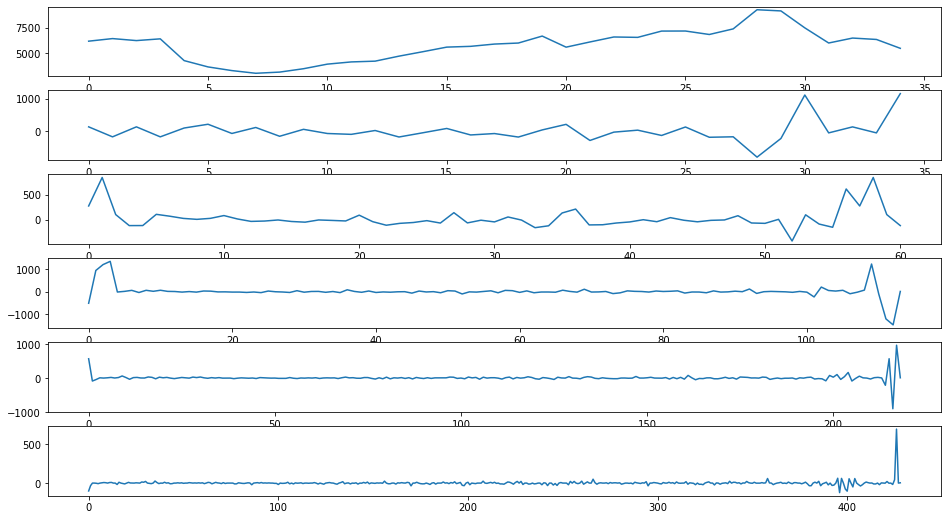

In [66]:
from matplotlib import pyplot as plt
ax = None
if ax is None:
    f, ax = plt.subplots(len(coeffs), figsize=(16, 9))

for i, coef in enumerate(coeffs):
    ax[i].plot(coef)

(0.0, 848.0)

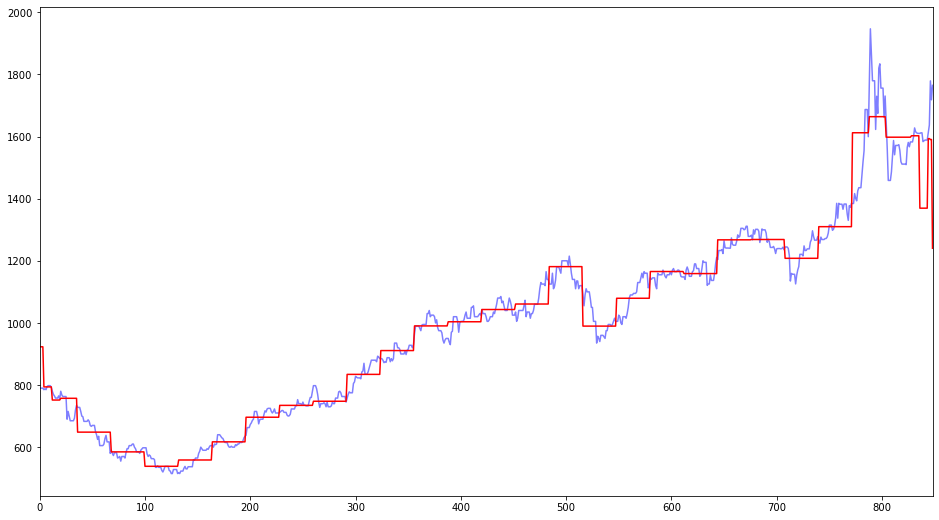

In [67]:
x = np.arange(len(prices))
# calculate a threshold
sigma = mad(coeffs[-level])
# changing this threshold also changes the behavior
uthresh = sigma * np.sqrt(2 * np.log(len(prices)))
coeffs[1:] = (pywt.threshold(i, value=uthresh, mode="soft") for i in coeffs[1:])
# reconstruct the signal using the thresholded coefficients
y = pywt.waverec(coeffs, wavelet, mode=mode)
f, ax = plt.subplots(figsize=(16, 9))
ax.plot(x, prices, color="b", alpha=0.5, label='raw signal')
ax.plot(x, y[:len(x)], color="r", label='denoised signal')
ax.set_xlim((0, np.max(x)))

In [87]:
vegetable_oil_production = pd.read_csv(os.path.join(DATA, 'vegetable-oil-production.csv'))
vegetable_oil_production = vegetable_oil_production[vegetable_oil_production['Entity'] != 'World']
year = vegetable_oil_production['Year'].drop_duplicates(keep='first', inplace=False)
vegetable_oil_production.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11010 entries, 0 to 11063
Data columns (total 16 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Entity                                                                     11010 non-null  object 
 1   Code                                                                       9269 non-null   object 
 2   Year                                                                       11010 non-null  int64  
 3   Crops processed - Oil, soybean - 237 - Production - 5510 - tonnes          5685 non-null   float64
 4   Crops processed - Oil, sesame - 290 - Production - 5510 - tonnes           4158 non-null   float64
 5   Crops processed - Oil, linseed - 334 - Production - 5510 - tonnes          4333 non-null   float64
 6   Crops processed - Oil, palm - 257 - Production - 5510 

In [88]:
veg_oil_by_country = vegetable_oil_production[~vegetable_oil_production['Code'].isnull()].copy()
veg_oil_by_country

,Entity,Code,Year,"Crops processed - Oil, soybean - 237 - Production - 5510 - tonnes","Crops processed - Oil, sesame - 290 - Production - 5510 - tonnes","Crops processed - Oil, linseed - 334 - Production - 5510 - tonnes","Crops processed - Oil, palm - 257 - Production - 5510 - tonnes","Crops processed - Oil, rapeseed - 271 - Production - 5510 - tonnes","Crops processed - Oil, groundnut - 244 - Production - 5510 - tonnes","Crops processed - Oil, cottonseed - 331 - Production - 5510 - tonnes","Crops processed - Oil, coconut (copra) - 252 - Production - 5510 - tonnes","Crops processed - Oil, olive, virgin - 261 - Production - 5510 - tonnes","Crops processed - Oil, safflower - 281 - Production - 5510 - tonnes","Crops processed - Oil, sunflower - 268 - Production - 5510 - tonnes","Crops processed - Oil, maize - 60 - Production - 5510 - tonnes","Crops processed - Oil, palm kernel - 258 - Production - 5510 - tonnes"
0,Afghanistan,AFG,1961,NaN,2253.0,3531.0,NaN,NaN,NaN,4997.0,NaN,82.0,NaN,2938.0,NaN,NaN
1,Afghanistan,AFG,1962,NaN,1876.0,3701.0,NaN,NaN,NaN,7716.0,NaN,90.0,NaN,3138.0,NaN,NaN
2,Afghanistan,AFG,1963,NaN,1831.0,2857.0,NaN,NaN,NaN,11742.0,NaN,82.0,NaN,3138.0,NaN,NaN
3,Afghanistan,AFG,1964,NaN,2722.0,3377.0,NaN,NaN,NaN,7960.0,NaN,90.0,NaN,3138.0,NaN,NaN
4,Afghanistan,AFG,1965,NaN,2821.0,4327.0,NaN,NaN,NaN,7926.0,NaN,82.0,NaN,3238.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,Zimbabwe,ZWE,1969,NaN,NaN,NaN,NaN,NaN,4242.0,3004.0,NaN,NaN,NaN,333.0,1800.0,NaN
11060,Zimbabwe,ZWE,1970,NaN,NaN,NaN,NaN,NaN,6006.0,9180.0,NaN,NaN,NaN,832.0,2250.0,NaN
11061,Zimbabwe,ZWE,1971,NaN,NaN,NaN,NaN,NaN,4284.0,10926.0,NaN,NaN,NaN,666.0,3600.0,NaN
11062,Zimbabwe,ZWE,1972,NaN,NaN,NaN,NaN,NaN,7980.0,11844.0,NaN,NaN,NaN,999.0,4500.0,NaN


In [89]:
veg_oil_by_area = vegetable_oil_production[vegetable_oil_production['Code'].isnull()].copy()
veg_oil_by_area

,Entity,Code,Year,"Crops processed - Oil, soybean - 237 - Production - 5510 - tonnes","Crops processed - Oil, sesame - 290 - Production - 5510 - tonnes","Crops processed - Oil, linseed - 334 - Production - 5510 - tonnes","Crops processed - Oil, palm - 257 - Production - 5510 - tonnes","Crops processed - Oil, rapeseed - 271 - Production - 5510 - tonnes","Crops processed - Oil, groundnut - 244 - Production - 5510 - tonnes","Crops processed - Oil, cottonseed - 331 - Production - 5510 - tonnes","Crops processed - Oil, coconut (copra) - 252 - Production - 5510 - tonnes","Crops processed - Oil, olive, virgin - 261 - Production - 5510 - tonnes","Crops processed - Oil, safflower - 281 - Production - 5510 - tonnes","Crops processed - Oil, sunflower - 268 - Production - 5510 - tonnes","Crops processed - Oil, maize - 60 - Production - 5510 - tonnes","Crops processed - Oil, palm kernel - 258 - Production - 5510 - tonnes"
54,Africa,NaN,1961,2337.0,23706.0,10917.0,1131882.0,31180.0,448152.0,166846.0,35923.0,77143.0,3810.0,33811.0,60192.0,77279.0
55,Africa,NaN,1962,2893.0,30158.0,9627.0,1111006.0,22141.0,517235.0,163605.0,37781.0,87970.0,3752.0,30479.0,62217.0,72627.0
56,Africa,NaN,1963,853.0,30177.0,7144.0,1145004.0,28708.0,577561.0,211456.0,44069.0,143734.0,3818.0,33889.0,64525.0,67875.0
57,Africa,NaN,1964,2312.0,25252.0,10791.0,1160831.0,26614.0,552984.0,180852.0,42435.0,143327.0,3703.0,30011.0,62547.0,78443.0
58,Africa,NaN,1965,1984.0,29208.0,14285.0,1138860.0,24215.0,646906.0,242830.0,42180.0,112610.0,3784.0,27358.0,65229.0,95883.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10812,Western Asia,NaN,2010,528876.0,92769.0,2270.0,NaN,478099.0,11589.0,286082.0,7.0,443892.0,0.0,744693.0,68699.0,NaN
10813,Western Asia,NaN,2011,455841.0,89268.0,12924.0,NaN,446379.0,10886.0,332377.0,227.0,461490.0,0.0,838192.0,64937.0,NaN
10814,Western Asia,NaN,2012,395594.0,91205.0,34718.0,NaN,378278.0,9998.0,308910.0,133.0,471316.0,37.0,795581.0,82235.0,NaN
10815,Western Asia,NaN,2013,391071.0,82693.0,16731.0,NaN,369019.0,9577.0,280947.0,27.0,416862.0,42.0,837072.0,98291.0,NaN


In [90]:
veg_oil_yearly_production = veg_oil_by_country.groupby('Year').sum()
veg_oil_yearly_production.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 1961 to 2014
Data columns (total 13 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   Crops processed - Oil, soybean - 237 - Production - 5510 - tonnes          54 non-null     float64
 1   Crops processed - Oil, sesame - 290 - Production - 5510 - tonnes           54 non-null     float64
 2   Crops processed - Oil, linseed - 334 - Production - 5510 - tonnes          54 non-null     float64
 3   Crops processed - Oil, palm - 257 - Production - 5510 - tonnes             54 non-null     float64
 4   Crops processed - Oil, rapeseed - 271 - Production - 5510 - tonnes         54 non-null     float64
 5   Crops processed - Oil, groundnut - 244 - Production - 5510 - tonnes        54 non-null     float64
 6   Crops processed - Oil, cottonseed - 331 - Production - 

In [91]:
import re
pattern = r'(?<=Oil, ).+?(?= - \d)'
cols = [re.search(pattern, c, re.RegexFlag.IGNORECASE)[0] for c in veg_oil_yearly_production]
cols = [re.sub(' ', '_', c) for c in cols]
cols = [re.sub('\W', '', c) for c in cols]

In [92]:
veg_oil_yearly_production.columns = cols
veg_oil_yearly_production.reset_index(inplace=True)
veg_oil_yearly_production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           54 non-null     int64  
 1   soybean        54 non-null     float64
 2   sesame         54 non-null     float64
 3   linseed        54 non-null     float64
 4   palm           54 non-null     float64
 5   rapeseed       54 non-null     float64
 6   groundnut      54 non-null     float64
 7   cottonseed     54 non-null     float64
 8   coconut_copra  54 non-null     float64
 9   olive_virgin   54 non-null     float64
 10  safflower      54 non-null     float64
 11  sunflower      54 non-null     float64
 12  maize          54 non-null     float64
 13  palm_kernel    54 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 6.0 KB


In [93]:
veg_oil_fig = px.area(
    veg_oil_yearly_production,
    x='Year',
    y=veg_oil_yearly_production.columns[1:]
)
veg_oil_fig.update_traces(textfont_size=16, hovertemplate=None)
veg_oil_fig.update_layout(hovermode="x")

veg_oil_fig.show()

In [94]:
veg_oil_yearly_production

,Year,soybean,sesame,linseed,palm,rapeseed,groundnut,cottonseed,coconut_copra,olive_virgin,safflower,sunflower,maize,palm_kernel
0,1961,3037151.0,376688.0,833972.0,1479101.0,1094042.0,2482640.0,2182397.0,1656633.0,1359340.0,91183.0,1945145.0,346546.0,476229.0
1,1962,3314136.0,446366.0,956169.0,1476141.0,1158704.0,2592954.0,2267912.0,2014666.0,931298.0,154331.0,2291303.0,364721.0,472833.0
2,1963,3558007.0,444734.0,920996.0,1535270.0,1117953.0,2809981.0,2462267.0,1952232.0,1807877.0,152774.0,2408407.0,374168.0,440997.0
3,1964,3538521.0,464334.0,927744.0,1570232.0,1076421.0,2894609.0,2638865.0,1866058.0,936277.0,123028.0,2362334.0,393323.0,478057.0
4,1965,3825235.0,455541.0,1028719.0,1576413.0,1533002.0,2649761.0,2763883.0,1923358.0,1244506.0,124893.0,3022958.0,430068.0,497071.0
5,1966,4316415.0,422708.0,911148.0,1666405.0,1525107.0,2722542.0,2793722.0,2120232.0,1286487.0,180332.0,3032815.0,435392.0,497999.0
6,1967,4615535.0,453525.0,800576.0,1669417.0,1634314.0,2948028.0,2408307.0,1989787.0,1358816.0,182249.0,3507762.0,441913.0,426873.0
7,1968,4626857.0,484295.0,789436.0,1823924.0,1805909.0,2694486.0,2376942.0,1910839.0,1502536.0,123658.0,3674740.0,445339.0,439208.0
8,1969,5049043.0,475000.0,803834.0,1942871.0,1704012.0,2801919.0,2586107.0,1885552.0,1288796.0,137742.0,3653089.0,468093.0,491381.0
9,1970,6268195.0,512208.0,1016002.0,1937739.0,1866874.0,3181101.0,2501339.0,1977428.0,1405284.0,154979.0,3651199.0,486680.0,498467.0


In [95]:
vegetable_oil_production['Entity'].unique()


array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'American Samoa',
       'Americas', 'Angola', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Asia', 'Asia, Central', 'Australia',
       'Australia & New Zealand', 'Austria', 'Azerbaijan', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belgium-Luxembourg', 'Belize',
       'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Caribbean', 'Central African Republic',
       'Central America', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo', 'Cook Islands', 'Costa Rica', "Cote d'Ivoire", 'Croatia',
       'Cuba', 'Cyprus', 'Czechia', 'Czechoslovakia',
       'Democratic Republic of Congo', 'Denmark', 'Dominica',
       'Dominican Republic', 'Eastern Africa', 'Eastern Asia',
       'Eastern Europe', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopi

In [96]:
vegetable_oil_production['Code'].unique()

array(['AFG', nan, 'ALB', 'DZA', 'ASM', 'AGO', 'ATG', 'ARG', 'ARM', 'AUS',
       'AUT', 'AZE', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BOL',
       'BIH', 'BWA', 'BRA', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN',
       'CAF', 'TCD', 'CHL', 'CHN', 'COL', 'COM', 'COG', 'COK', 'CRI',
       'CIV', 'HRV', 'CUB', 'CYP', 'CZE', 'OWID_CZS', 'COD', 'DNK', 'DMA',
       'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH',
       'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA',
       'GRC', 'GRD', 'GLP', 'GUM', 'GTM', 'GIN', 'GNB', 'GUY', 'HTI',
       'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL',
       'ISR', 'ITA', 'JAM', 'JPN', 'JOR', 'KAZ', 'KEN', 'KIR', 'KWT',
       'KGZ', 'LAO', 'LVA', 'LBN', 'LBR', 'LBY', 'LTU', 'LUX', 'MDG',
       'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MRT', 'MUS', 'OWID_MNS', 'MEX',
       'FSM', 'MDA', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NPL',
       'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'PRK', 'MKD', 'NOR',
     

In [97]:
vegetable_oil_production[vegetable_oil_production['Code'].isnull()]

,Entity,Code,Year,"Crops processed - Oil, soybean - 237 - Production - 5510 - tonnes","Crops processed - Oil, sesame - 290 - Production - 5510 - tonnes","Crops processed - Oil, linseed - 334 - Production - 5510 - tonnes","Crops processed - Oil, palm - 257 - Production - 5510 - tonnes","Crops processed - Oil, rapeseed - 271 - Production - 5510 - tonnes","Crops processed - Oil, groundnut - 244 - Production - 5510 - tonnes","Crops processed - Oil, cottonseed - 331 - Production - 5510 - tonnes","Crops processed - Oil, coconut (copra) - 252 - Production - 5510 - tonnes","Crops processed - Oil, olive, virgin - 261 - Production - 5510 - tonnes","Crops processed - Oil, safflower - 281 - Production - 5510 - tonnes","Crops processed - Oil, sunflower - 268 - Production - 5510 - tonnes","Crops processed - Oil, maize - 60 - Production - 5510 - tonnes","Crops processed - Oil, palm kernel - 258 - Production - 5510 - tonnes"
54,Africa,NaN,1961,2337.0,23706.0,10917.0,1131882.0,31180.0,448152.0,166846.0,35923.0,77143.0,3810.0,33811.0,60192.0,77279.0
55,Africa,NaN,1962,2893.0,30158.0,9627.0,1111006.0,22141.0,517235.0,163605.0,37781.0,87970.0,3752.0,30479.0,62217.0,72627.0
56,Africa,NaN,1963,853.0,30177.0,7144.0,1145004.0,28708.0,577561.0,211456.0,44069.0,143734.0,3818.0,33889.0,64525.0,67875.0
57,Africa,NaN,1964,2312.0,25252.0,10791.0,1160831.0,26614.0,552984.0,180852.0,42435.0,143327.0,3703.0,30011.0,62547.0,78443.0
58,Africa,NaN,1965,1984.0,29208.0,14285.0,1138860.0,24215.0,646906.0,242830.0,42180.0,112610.0,3784.0,27358.0,65229.0,95883.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10812,Western Asia,NaN,2010,528876.0,92769.0,2270.0,NaN,478099.0,11589.0,286082.0,7.0,443892.0,0.0,744693.0,68699.0,NaN
10813,Western Asia,NaN,2011,455841.0,89268.0,12924.0,NaN,446379.0,10886.0,332377.0,227.0,461490.0,0.0,838192.0,64937.0,NaN
10814,Western Asia,NaN,2012,395594.0,91205.0,34718.0,NaN,378278.0,9998.0,308910.0,133.0,471316.0,37.0,795581.0,82235.0,NaN
10815,Western Asia,NaN,2013,391071.0,82693.0,16731.0,NaN,369019.0,9577.0,280947.0,27.0,416862.0,42.0,837072.0,98291.0,NaN


In [98]:
vegetable_oil_production[vegetable_oil_production['Entity'] == 'Australia']

,Entity,Code,Year,"Crops processed - Oil, soybean - 237 - Production - 5510 - tonnes","Crops processed - Oil, sesame - 290 - Production - 5510 - tonnes","Crops processed - Oil, linseed - 334 - Production - 5510 - tonnes","Crops processed - Oil, palm - 257 - Production - 5510 - tonnes","Crops processed - Oil, rapeseed - 271 - Production - 5510 - tonnes","Crops processed - Oil, groundnut - 244 - Production - 5510 - tonnes","Crops processed - Oil, cottonseed - 331 - Production - 5510 - tonnes","Crops processed - Oil, coconut (copra) - 252 - Production - 5510 - tonnes","Crops processed - Oil, olive, virgin - 261 - Production - 5510 - tonnes","Crops processed - Oil, safflower - 281 - Production - 5510 - tonnes","Crops processed - Oil, sunflower - 268 - Production - 5510 - tonnes","Crops processed - Oil, maize - 60 - Production - 5510 - tonnes","Crops processed - Oil, palm kernel - 258 - Production - 5510 - tonnes"
574,Australia,AUS,1961,22.0,NaN,3556.0,NaN,NaN,668.0,716.0,18526.0,97.0,470.0,901.0,194.0,NaN
575,Australia,AUS,1962,50.0,NaN,8030.0,NaN,NaN,479.0,575.0,18904.0,86.0,422.0,531.0,243.0,NaN
576,Australia,AUS,1963,180.0,NaN,9226.0,NaN,NaN,521.0,537.0,19653.0,95.0,1513.0,1188.0,413.0,NaN
577,Australia,AUS,1964,313.0,NaN,16338.0,NaN,NaN,727.0,693.0,19452.0,146.0,3734.0,978.0,425.0,NaN
578,Australia,AUS,1965,925.0,NaN,1828.0,NaN,NaN,607.0,2887.0,19470.0,95.0,2702.0,881.0,462.0,NaN
579,Australia,AUS,1966,233.0,70.0,4371.0,NaN,NaN,1018.0,5908.0,19681.0,159.0,7405.0,1522.0,547.0,NaN
580,Australia,AUS,1967,129.0,74.0,3036.0,NaN,NaN,1231.0,4259.0,19721.0,118.0,4856.0,850.0,401.0,NaN
581,Australia,AUS,1968,136.0,85.0,9611.0,NaN,NaN,835.0,8160.0,17533.0,197.0,3170.0,1394.0,462.0,NaN
582,Australia,AUS,1969,233.0,136.0,12359.0,NaN,2000.0,480.0,8638.0,18668.0,202.0,981.0,2730.0,462.0,NaN
583,Australia,AUS,1970,638.0,172.0,12273.0,NaN,13000.0,1416.0,7092.0,16564.0,175.0,2560.0,5469.0,462.0,NaN


In [99]:
vegetable_oil_production[vegetable_oil_production['Entity'] == 'New Zealand']

,Entity,Code,Year,"Crops processed - Oil, soybean - 237 - Production - 5510 - tonnes","Crops processed - Oil, sesame - 290 - Production - 5510 - tonnes","Crops processed - Oil, linseed - 334 - Production - 5510 - tonnes","Crops processed - Oil, palm - 257 - Production - 5510 - tonnes","Crops processed - Oil, rapeseed - 271 - Production - 5510 - tonnes","Crops processed - Oil, groundnut - 244 - Production - 5510 - tonnes","Crops processed - Oil, cottonseed - 331 - Production - 5510 - tonnes","Crops processed - Oil, coconut (copra) - 252 - Production - 5510 - tonnes","Crops processed - Oil, olive, virgin - 261 - Production - 5510 - tonnes","Crops processed - Oil, safflower - 281 - Production - 5510 - tonnes","Crops processed - Oil, sunflower - 268 - Production - 5510 - tonnes","Crops processed - Oil, maize - 60 - Production - 5510 - tonnes","Crops processed - Oil, palm kernel - 258 - Production - 5510 - tonnes"
6658,New Zealand,NZL,1961,NaN,NaN,1762.0,NaN,NaN,NaN,NaN,2505.0,NaN,NaN,NaN,22.0,NaN
6659,New Zealand,NZL,1962,NaN,NaN,2526.0,NaN,NaN,NaN,NaN,2555.0,NaN,NaN,NaN,43.0,NaN
6660,New Zealand,NZL,1963,NaN,NaN,3071.0,NaN,NaN,NaN,NaN,2067.0,NaN,NaN,NaN,47.0,NaN
6661,New Zealand,NZL,1964,NaN,NaN,3080.0,NaN,NaN,NaN,NaN,1939.0,NaN,NaN,NaN,65.0,NaN
6662,New Zealand,NZL,1965,NaN,NaN,1694.0,NaN,NaN,NaN,NaN,2200.0,NaN,NaN,NaN,76.0,NaN
6663,New Zealand,NZL,1966,NaN,NaN,1759.0,NaN,NaN,NaN,NaN,1721.0,NaN,NaN,NaN,83.0,NaN
6664,New Zealand,NZL,1967,NaN,NaN,2216.0,NaN,NaN,NaN,NaN,2695.0,NaN,NaN,NaN,77.0,NaN
6665,New Zealand,NZL,1968,NaN,NaN,1472.0,NaN,NaN,NaN,NaN,3260.0,NaN,NaN,NaN,97.0,NaN
6666,New Zealand,NZL,1969,NaN,NaN,3288.0,NaN,NaN,NaN,NaN,3133.0,NaN,NaN,NaN,124.0,NaN
6667,New Zealand,NZL,1970,NaN,NaN,3754.0,NaN,NaN,NaN,NaN,2923.0,NaN,NaN,NaN,69.0,NaN


In [100]:
import plotly.graph_objects as go
help(go.Choropleth)

Help on class Choropleth in module plotly.graph_objs._choropleth:

class Choropleth(plotly.basedatatypes.BaseTraceType)
 |  Choropleth(arg=None, autocolorscale=None, coloraxis=None, colorbar=None, colorscale=None, customdata=None, customdatasrc=None, featureidkey=None, geo=None, geojson=None, hoverinfo=None, hoverinfosrc=None, hoverlabel=None, hovertemplate=None, hovertemplatesrc=None, hovertext=None, hovertextsrc=None, ids=None, idssrc=None, legendgroup=None, legendgrouptitle=None, legendrank=None, locationmode=None, locations=None, locationssrc=None, marker=None, meta=None, metasrc=None, name=None, reversescale=None, selected=None, selectedpoints=None, showlegend=None, showscale=None, stream=None, text=None, textsrc=None, uid=None, uirevision=None, unselected=None, visible=None, z=None, zauto=None, zmax=None, zmid=None, zmin=None, zsrc=None, **kwargs)
 |  
 |  Base class for the all trace types.
 |  
 |  Specific trace type classes (Scatter, Bar, etc.) are code generated as
 |  subcl

In [101]:
cols_to_rename = veg_oil_by_country.columns[3:]

cols = [re.search(pattern, c, re.RegexFlag.IGNORECASE)[0] for c in cols_to_rename]
cols = [re.sub(' ', '_', c) for c in cols]
cols = [re.sub('\W', '', c) for c in cols]

veg_oil_by_country.columns = veg_oil_by_country.columns.tolist()[:3] + cols
veg_oil_by_country

,Entity,Code,Year,soybean,sesame,linseed,palm,rapeseed,groundnut,cottonseed,coconut_copra,olive_virgin,safflower,sunflower,maize,palm_kernel
0,Afghanistan,AFG,1961,NaN,2253.0,3531.0,NaN,NaN,NaN,4997.0,NaN,82.0,NaN,2938.0,NaN,NaN
1,Afghanistan,AFG,1962,NaN,1876.0,3701.0,NaN,NaN,NaN,7716.0,NaN,90.0,NaN,3138.0,NaN,NaN
2,Afghanistan,AFG,1963,NaN,1831.0,2857.0,NaN,NaN,NaN,11742.0,NaN,82.0,NaN,3138.0,NaN,NaN
3,Afghanistan,AFG,1964,NaN,2722.0,3377.0,NaN,NaN,NaN,7960.0,NaN,90.0,NaN,3138.0,NaN,NaN
4,Afghanistan,AFG,1965,NaN,2821.0,4327.0,NaN,NaN,NaN,7926.0,NaN,82.0,NaN,3238.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11059,Zimbabwe,ZWE,1969,NaN,NaN,NaN,NaN,NaN,4242.0,3004.0,NaN,NaN,NaN,333.0,1800.0,NaN
11060,Zimbabwe,ZWE,1970,NaN,NaN,NaN,NaN,NaN,6006.0,9180.0,NaN,NaN,NaN,832.0,2250.0,NaN
11061,Zimbabwe,ZWE,1971,NaN,NaN,NaN,NaN,NaN,4284.0,10926.0,NaN,NaN,NaN,666.0,3600.0,NaN
11062,Zimbabwe,ZWE,1972,NaN,NaN,NaN,NaN,NaN,7980.0,11844.0,NaN,NaN,NaN,999.0,4500.0,NaN


In [102]:
veg_oil_type = 'palm'
fig = go.Figure(
    data=go.Choropleth(
        locations=veg_oil_by_country['Code'],
        z=veg_oil_by_country[veg_oil_type],
        locationmode='ISO-3',  #  "ISO-3" | "USA-states" | "country names"
        colorscale='Viridis',
        colorbar_title=veg_oil_type
    )
)
fig.update_layout(
    title_text = f'{veg_oil_type} Vegetable Oil',
)

fig.show()

In [103]:
geo_fig = px.choropleth(
    veg_oil_by_country,
    locations='Code',
    color=veg_oil_type,
    color_continuous_scale=px.colors.diverging.PiYG,
    locationmode='ISO-3',
    animation_frame='Year',
    projection='natural earth'
)
geo_fig.update_layout(
    title_text = f'{veg_oil_type} Vegetable Oil',
)

geo_fig.show()

In [104]:
veg_oil_by_country[veg_oil_by_country['palm'] > 40_000_000]

,Entity,Code,Year,soybean,sesame,linseed,palm,rapeseed,groundnut,cottonseed,coconut_copra,olive_virgin,safflower,sunflower,maize,palm_kernel
